Data loading

In [1]:
from google.colab import files
uploaded = files.upload()

Saving D&O.csv to D&O.csv


Load libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os
import io

In [3]:
df = pd.read_csv(io.BytesIO(uploaded['D&O.csv']), index_col='Date', parse_dates=['Date'])
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-28,0.390,0.495,0.390,0.46,0.425383,77841700.0
2004-12-29,0.465,0.510,0.460,0.50,0.462373,19786600.0
2004-12-30,0.500,0.510,0.475,0.48,0.443878,6846700.0
2004-12-31,0.485,0.510,0.480,0.49,0.453125,8420300.0
2005-01-03,0.500,0.520,0.485,0.51,0.471620,7385000.0
...,...,...,...,...,...,...
2021-05-19,4.350,4.420,4.040,4.11,4.110000,12099800.0
2021-05-20,4.190,4.330,4.000,4.04,4.040000,9428200.0
2021-05-21,4.140,4.290,3.920,4.20,4.200000,9529800.0


We choose High and Volume as two attributes to consider in our model and remove some null values.

In [4]:
df = df.drop(['Open', 'Low', 'Close', 'Adj Close'], axis=1)
df = df.dropna()

In [5]:
minMaxScaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = minMaxScaler.fit_transform(df)

### GRU

In [6]:
def CreateData(df, future, past, train_test_split_percentage, validation_split_percentage):
  feature = df.shape[1]
  x_data, y_data = [], []

  for i in range(past, len(df) - future + 1):
    x_data.append(df[i - past:i, 0:feature])
    y_data.append(df[i + future - 1:i + future, 0])

  split_training_test_starting_point = int(round(train_test_split_percentage * len(x_data)))
  split_train_validation_starting_point = int(round(split_training_test_starting_point * (1 - validation_split_percentage)))

  X_train = x_data[:split_train_validation_starting_point]
  y_train = y_data[:split_train_validation_starting_point]

  X_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
  y_val = y_data[split_train_validation_starting_point:split_training_test_starting_point]

  X_test = x_data[split_training_test_starting_point:]
  y_test = y_data[split_training_test_starting_point:]

  return np.array(X_train), np.array(X_test), np.array(X_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [7]:
X_train, X_test, X_val, y_train, y_test, y_val = CreateData(df_scaled, future=1, past=25, train_test_split_percentage=0.8, validation_split_percentage = 0)

#### GRU Training

In [ ]:
regressor = Sequential()

regressor.add(GRU(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(GRU(units=256, return_sequences=False))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=500, batch_size=64, callbacks=[early_stopping])

Epoch 1/500
33/33 [==============================] - 29s 287ms/step - loss: 6.1523e-04 - val_loss: 1.4659e-05
Epoch 2/500
33/33 [==============================] - 8s 248ms/step - loss: 2.7176e-05 - val_loss: 5.4195e-05
Epoch 3/500
33/33 [==============================] - 8s 248ms/step - loss: 2.5405e-05 - val_loss: 2.5281e-05
Epoch 4/500
33/33 [==============================] - 8s 246ms/step - loss: 2.1655e-05 - val_loss: 1.8921e-05
Epoch 5/500
33/33 [==============================] - 8s 245ms/step - loss: 2.8156e-05 - val_loss: 4.5832e-05
Epoch 6/500
33/33 [==============================] - 8s 249ms/step - loss: 2.3165e-05 - val_loss: 2.2755e-05
Epoch 7/500
33/33 [==============================] - 8s 250ms/step - loss: 2.0063e-05 - val_loss: 3.0788e-05
Epoch 8/500
33/33 [==============================] - 8s 248ms/step - loss: 2.1524e-05 - val_loss: 2.7764e-05
Epoch 9/500
33/33 [==============================] - 8s 243ms/step - loss: 1.8551e-05 - val_loss: 3.2296e-05
Epoch 10/500
33/33

#### Hyperparameter Tuning

In [8]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Tune the number of layers and neurons in each layer

In [ ]:
def CreateModel(n_layers, n_nodes):
  model = Sequential()
  input_shape = (25, 2)

  for i in range(1, n_layers):
    if i == 1:
      model.add(GRU(units=n_nodes, return_sequences=True, input_shape=input_shape))
    else:
      model.add(GRU(units=n_nodes, return_sequences=False))

  model.add(Dense(units=1, activation='linear'))
  model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  return model

In [ ]:
n_layers = [3, 4, 5]
n_nodes = [128, 256]

model = KerasClassifier(build_fn=CreateModel, verbose=False)
param_grid = dict(n_layers=n_layers, n_nodes=n_nodes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Best Parameters: {grid.best_params_}')

Best Score: 0.01670006662607193
Best Parameters: {'n_layers': 3, 'n_nodes': 128}


Tune the optimization algorithm

In [17]:
def CreateModel(optimizer):
  model = Sequential()
  input_shape = (25, 2)
  n_layers = 3
  n_nodes = 128
  activation = 'tanh'
  final_activation = 'linear'
  loss = 'huber'

  for i in range(1, n_layers):
    if i == 1:
      model.add(GRU(units=n_nodes, return_sequences=True, input_shape=input_shape, activation=activation))
    else:
      model.add(GRU(units=n_nodes, return_sequences=False, activation=activation))

  model.add(Dense(units=1, activation=final_activation))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [18]:
optimizer = ['Adam', 'Adamax', 'Nadam']

model = KerasClassifier(build_fn=CreateModel, batch_size=100, epochs=100, verbose=False)
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Best Parameters: {grid.best_params_}')

Best Score: 0.01670006662607193
Best Parameters: {'optimizer': 'Adam'}


Tune learning rate of optimization algorithm

In [11]:
from keras.optimizers import Adam

In [19]:
def CreateModel(learning_rate, beta_1, beta_2):
  model = Sequential()
  input_shape = (25, 2)
  n_layers = 3
  n_nodes = 128
  activation = 'tanh'
  final_activation = 'linear'
  loss = 'huber'
  optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

  for i in range(1, n_layers):
    if i == 1:
      model.add(GRU(units=n_nodes, return_sequences=True, input_shape=input_shape, activation=activation))
    else:
      model.add(GRU(units=n_nodes, return_sequences=False, activation=activation))

  model.add(Dense(units=1, activation=final_activation))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [20]:
learning_rate = [0.001, 0.01]
beta_1 = [0.6, 0.8]
beta_2 = [0.9, 0.95]

model = KerasClassifier(build_fn=CreateModel, batch_size=100, epochs=60, verbose=False)
param_grid = dict(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Best Parameters: {grid.best_params_}')

Best Score: 0.08350033561388652
Best Parameters: {'beta_1': 0.6, 'beta_2': 0.9, 'learning_rate': 0.001}


Tune network weight initialization

In [21]:
def CreateModel(kernel_initializer):
  model = Sequential()
  input_shape = (25, 2)
  n_layers = 3
  n_nodes = 128
  activation = 'tanh'
  final_activation = 'linear'
  loss = 'huber'
  learning_rate = 0.001
  beta_1 = 0.6  
  beta_2 = 0.9
  optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

  for i in range(1, n_layers):
    if i == 1:
      model.add(GRU(units=n_nodes, return_sequences=True, input_shape=input_shape, activation=activation, kernel_initializer=kernel_initializer))
    else:
      model.add(GRU(units=n_nodes, return_sequences=False, activation=activation, kernel_initializer=kernel_initializer))

  model.add(Dense(units=1, activation=final_activation))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [16]:
kernel_initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

model = KerasClassifier(build_fn=CreateModel, batch_size=100, epochs=60, verbose=False)
param_grid = dict(kernel_initializer=kernel_initializer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Best Parameters: {grid.best_params_}')

Best Score: 0.08283233145872752
Best Parameters: {'kernel_initializer': 'normal'}


Tune the dropout regularization

In [22]:
def CreateModel(dropout_rate):
  model = Sequential()
  input_shape = (25, 2)
  n_layers = 3
  n_nodes = 128
  activation = 'tanh'
  final_activation = 'linear'
  loss = 'huber'
  learning_rate = 0.001
  beta_1 = 0.6  
  beta_2 = 0.9
  kernel_initializer = 'normal'
  optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

  for i in range(1, n_layers):
    if i == 1:
      model.add(GRU(units=n_nodes, return_sequences=True, input_shape=input_shape, activation=activation, kernel_initializer=kernel_initializer))
      model.add(Dropout(dropout_rate))
    else:
      model.add(GRU(units=n_nodes, return_sequences=False, activation=activation, kernel_initializer=kernel_initializer))
      model.add(Dropout(dropout_rate))

  model.add(Dense(units=1, activation=final_activation))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [23]:
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

model = KerasClassifier(build_fn=CreateModel, batch_size=100, epochs=60, verbose=False)
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Best Parameters: {grid.best_params_}')

Best Score: 0.08283233145872752
Best Parameters: {'dropout_rate': 0.2}


Early stopping and callbacks

In [26]:
def CreateModel():
  model = Sequential()
  input_shape = (25, 2)
  n_layers = 3
  n_nodes = 128
  activation = 'tanh'
  final_activation = 'linear'
  loss = 'huber'
  learning_rate = 0.001
  beta_1 = 0.6  
  beta_2 = 0.9
  kernel_initializer = 'normal'
  dropout_rate = 0.2
  optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

  for i in range(1, n_layers):
    if i == 1:
      model.add(GRU(units=n_nodes, return_sequences=True, input_shape=input_shape, activation=activation, kernel_initializer=kernel_initializer))
      model.add(Dropout(dropout_rate))
    else:
      model.add(GRU(units=n_nodes, return_sequences=False, activation=activation, kernel_initializer=kernel_initializer))
      model.add(Dropout(dropout_rate))

  model.add(Dense(units=1, activation=final_activation))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
file_path = 'best_model.h5'
model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
model = CreateModel()
model.fit(X_train, y_train, validation_split=0.3, epochs=500, batch_size=50, callbacks=[early_stopping, model_checkpoint], verbose=0)


Epoch 00001: val_loss improved from inf to 0.00012, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.00012 to 0.00004, saving model to best_model.h5

Epoch 00003: val_loss did not improve from 0.00004

Epoch 00004: val_loss did not improve from 0.00004

Epoch 00005: val_loss improved from 0.00004 to 0.00003, saving model to best_model.h5

Epoch 00006: val_loss improved from 0.00003 to 0.00002, saving model to best_model.h5

Epoch 00007: val_loss did not improve from 0.00002

Epoch 00008: val_loss improved from 0.00002 to 0.00001, saving model to best_model.h5

Epoch 00009: val_loss did not improve from 0.00001

Epoch 00010: val_loss did not improve from 0.00001

Epoch 00011: val_loss did not improve from 0.00001

Epoch 00012: val_loss did not improve from 0.00001

Epoch 00013: val_loss improved from 0.00001 to 0.00001, saving model to best_model.h5

Epoch 00014: val_loss did not improve from 0.00001

Epoch 00015: val_loss improved from 0.00001 to 0.00001, saving mo

In [29]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 14ms/step - loss: 8.3881e-04 - accuracy: 0.0013


[0.0008388084243051708, 0.0013351135421544313]

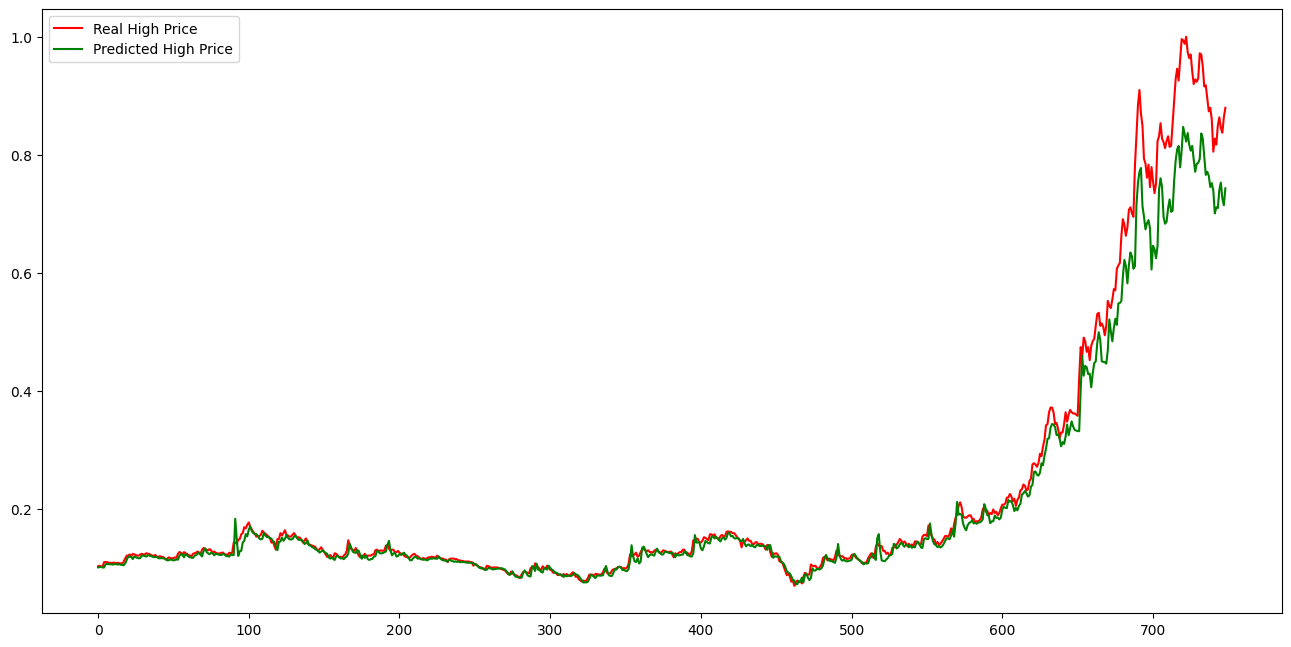

In [30]:
y_pred = model.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real High Price')
plt.plot(y_pred, color='green', label = 'Predicted High Price')
plt.legend(loc='best')

In [31]:
saved_model = load_model('best_model.h5')

In [32]:
saved_model.evaluate(X_test, y_test)

24/24 [==============================] - 1s 15ms/step - loss: 3.4366e-04 - accuracy: 0.0013


[0.00034366108593530953, 0.0013351135421544313]

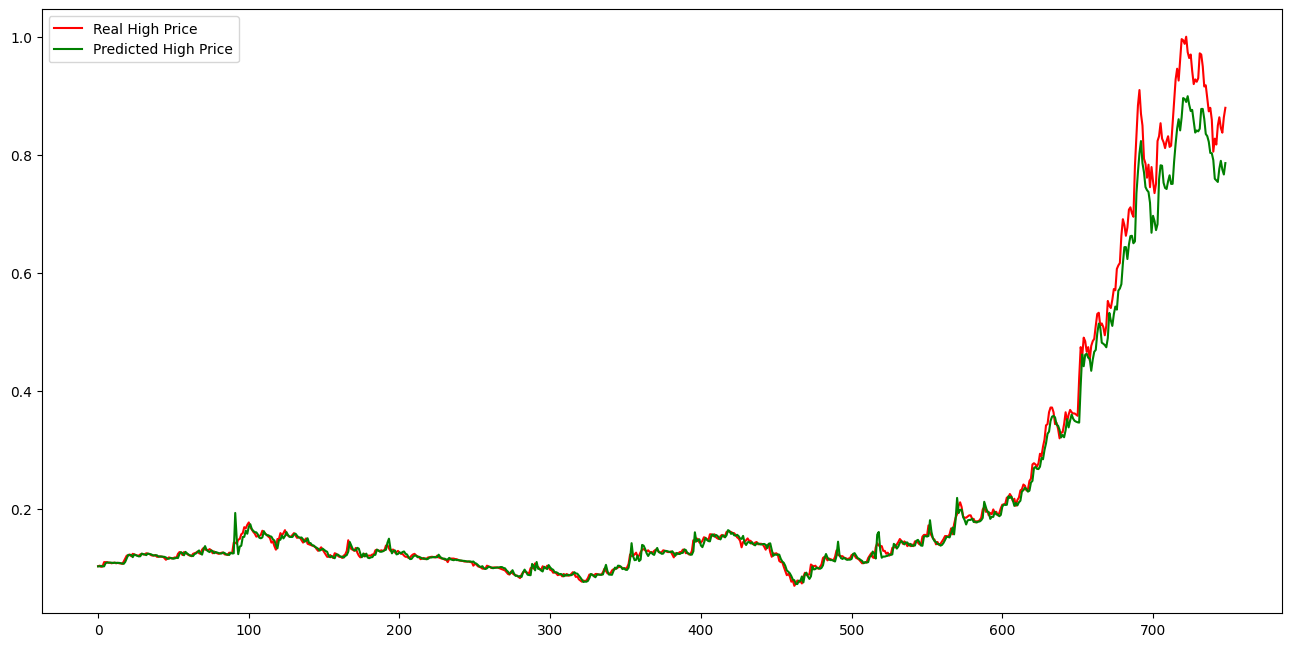

In [33]:
y_pred = saved_model.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real High Price')
plt.plot(y_pred, color='green', label = 'Predicted High Price')
plt.legend(loc='best')